# Seq2seq 번역기

## 프로젝트 목표

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.	
- 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. Attentional Seq2seq 모델이 정상적으로 구동된다.	
- seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	
- 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.

## 프로세스

1. 데이터 다운로드
- 아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

    - jungyeul/korean-parallel-corpora

2. 데이터 정제
- set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 
- 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

- 앞 서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 
- 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

- 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 
- 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

- 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. 
- cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

3. 데이터 토큰화
- 앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 
- 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)
    
    - 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

4. 모델 설계
- 한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 
- 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! 
- Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

5. 훈련하기
- 훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 
- 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! 
    (Attention Map을 시각화해보는 것도 재밌을 거예요!)

    - 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

## 코드 구현

In [1]:
import tensorflow as tf
import numpy as np
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from tqdm import tqdm    # tqdm
import random

import time
import re
import os
import io

In [2]:
# 한글 폰트 지정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("한글 폰트 지정 완료!")

한글 폰트 지정 완료!


In [3]:
# 데이터 로드
data_path = "data"
kor_file = os.path.join(data_path, "korean-english-park.train.ko")  # 한국어 파일
eng_file = os.path.join(data_path, "korean-english-park.train.en")  # 영어 파일

with open(kor_file, "r", encoding="utf-8") as f_ko, open(eng_file, "r", encoding="utf-8") as f_en:
    korean_sentences = f_ko.readlines()
    english_sentences = f_en.readlines()
    
# 데이터 길이 체크
# assert 뒤의 내용이 True면 패스, False면 에러발생
# https://wikidocs.net/21050
assert len(korean_sentences) == len(english_sentences), "파일 길이가 다릅니다!"

In [4]:
# 중복 제거
cleaned_corpus = set(zip(korean_sentences, english_sentences))
cleaned_korean, cleaned_english = zip(*cleaned_corpus)

In [5]:
print("Data Size:", len(cleaned_corpus))

for i in range (0,10):
    print(f"KOR {i} : ", cleaned_korean[i] ,f"ENG {i} : ", cleaned_english[i])

Data Size: 78968
KOR 0 :  58세의 울머는 팀이 크리켓 월드컵에서 아일랜드에 패한 후 지난 3월 18일 킹스톤 호텔의 방에서 혼수 상태로 발견되었다.
 ENG 0 :  Woolmer, who was 58, died after being found unconscious in his Kingston hotel room on 18 March, following his team’s loss to Ireland in the cricket World Cup.

KOR 1 :  후주석이 자신의 발언에서 누차 입장을 밝혔듯이, 폐쇄적인 북한의 핵심 동맹국인 중국은 한반도가 비핵화되기를 원한다고 말해왔다.
 ENG 1 :  China is reclusive North Korea's leading ally and has said it wants Korean Peninsula free of nuclear weapons _ a stand Hu repeated in his comments.

KOR 2 :  이에 검찰은 이번 자살 사건이 이미 껄끄러워질대로 껄끄러워진 경찰과의 관계를 더욱 악화시켜 사건 수사에 영향을 주지 않을까 우려하고 있다.
 ENG 2 :  Prosecutors are concerned whether this latest incident will influence their investigation over the case by scratching their already touchy relationship with police.

KOR 3 :  뉴욕 양키스의 조 지라디 감독이 10일(현지시간) 열린 캔자스시티 로열스와의 경기를 앞두고 타순을 긴급 조정했다.
 ENG 3 :  Manager Joe Girardi shook up the struggling New York Yankees' lineup before Thursday night's game against the Kansas City Royals.

KOR 4 :  하지만 예전 에 웹

In [6]:
for i in range (49990,50000):
    print(f"KOR {i} : ", cleaned_korean[i] ,f"ENG {i} : ", cleaned_english[i])

KOR 49990 :  한국은 1950년 미국에 작전권을 이양했다.
 ENG 49990 :  South Korea transferred control of its troops to the United States in 1950.

KOR 49991 :  티베트(시짱)자치구에서 발생한 20년만의 최악의 유혈사태에 대해 각국의 정부와 인권단체들은 올림픽 보이콧 필요성을 역설했다.
 ENG 49991 :  Violent protests in Tibet, the most serious challenge in almost two decades to China's rule in the region, are forcing human rights campaigners and governments to re-examine their approach to the Olympic Games.

KOR 49992 :  직원들이 휴가 중이라는 것은 이 기간 동안 회사에는 인력이 부족하다는 것을 뜻한다.
 ENG 49992 :  Employees go on vacation, which leaves the company short on help during this time.

KOR 49993 :  이전 미얀마 양곤에 살다 태국으로 이주해온 주민은 “한 정부 관계자가 화를 내며 WFP에서 처음 미얀마 보내온 구호품인 과자들이 군 보급창으로 보내지고 있다고 말했다”고 전했다.
 ENG 49993 :  A former Yangon resident now living in Thailand told AP that angry government officials told him that high-energy biscuits rushed into Myanmar on the World Food Program's first flights were sent to a military warehouse.

KOR 49994 :  인수팀 관계자는 또한 보건위생, 교육, 에너지 소비 등 미래에 더 강력한 경제

In [7]:
# 한국어 텍스트 전처리 함수
def kor_preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence


# 영어 텍스트 전처리 함수
def eng_preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [8]:
enc_corpus = []
dec_corpus = []

num_examples = 50000

for kor, eng in list(cleaned_corpus)[:num_examples]:
    enc_corpus.append(kor_preprocess_sentence(kor))
    dec_corpus.append(eng_preprocess_sentence(eng, s_token=True, e_token=True))

print("kor:", enc_corpus[100])
print("eng:", dec_corpus[100]) 

kor: 레젭 타입 에르도간 터키 총리는 의회에서 여당 의원들에게 더 강력한 군사 행동을 취하는 것은 이제 피할 수 없게 됐다 고 밝혔다 .
eng: <start> prime minister recep tayyip erdogan told members of his party in parliament it is now unavoidable that turkey will have to go through a more intensive military process . <end>


In [9]:
print("kor:", enc_corpus[0])
print("eng:", dec_corpus[0]) 

kor: 58세의 울머는 팀이 크리켓 월드컵에서 아일랜드에 패한 후 지난 3월 18일 킹스톤 호텔의 방에서 혼수 상태로 발견되었다 .
eng: <start> woolmer , who was , died after being found unconscious in his kingston hotel room on march , following his team s loss to ireland in the cricket world cup . <end>


In [10]:
print("kor:", enc_corpus[3])
print("eng:", dec_corpus[3]) 

kor: 뉴욕 양키스의 조 지라디 감독이 10일 현지시간 열린 캔자스시티 로열스와의 경기를 앞두고 타순을 긴급 조정했다 .
eng: <start> manager joe girardi shook up the struggling new york yankees lineup before thursday night s game against the kansas city royals . <end>


In [11]:
print("kor len:", len(enc_corpus))
print("eng len:", len(dec_corpus) )

kor len: 50000
eng len: 50000


In [12]:
# 토큰나이저

mecab = Mecab()

# 한글 토크나이저
def tokenize_kor(corpus):
    # Mecab으로 문장을 토큰화한 후 리스트로 변환
    corpus = [" ".join(mecab.morphs(sentence)) for sentence in corpus]

    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=50, padding='post')

    return tensor, tokenizer

# 영어 토크나이저
def tokenize_eng(corpus):
    corpus = [" ".join(sentence.split()) for sentence in corpus]

    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen=60, padding='post')

    return tensor, tokenizer

In [13]:
enc_tensor, enc_tokenizer = tokenize_kor(enc_corpus)
dec_tensor, dec_tokenizer = tokenize_eng(dec_corpus)

print(enc_tensor[1])
print(dec_tensor[1])

[  131  1625     3    93     6   574    16 19897   526     5    41  4112
    17   708    31    23    80     6  1774  2685    23    89     8  1322
    15   311   183   227    36    32     9  6621    30    49   302     2
     1     0     0     0     0     0     0     0     0     0     0     0
     0     0]
[   4  119   16 4539   60   50   11  645 1979   10   25   12   19  639
   82 1014  377    7  114  404    8 1282 2272 2403    9   27  992    2
    5    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [14]:
print(len(enc_tokenizer.index_word))
print(len(dec_tokenizer.index_word))

43743
37773


In [15]:
# 훈련데이터 검증 데이터 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2, random_state=42)

In [16]:
# Bahdanau 어탠션 함수
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [17]:
# 인코더 함수
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [18]:
# 디코더 함수
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, dropout_rate=0.2):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
        # 드랍아웃 추가
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = self.dropout(out)
        
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [19]:
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (32, 30, 512)
Decoder Output: (32, 37774)
Decoder Hidden State: (32, 512)
Attention: (32, 30, 1)


In [20]:
max_sequence_length = enc_train.shape[1]
max_sequence_length


50

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [22]:
# train step 구현
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [23]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1250/1250 [05:32<00:00,  3.76it/s, Loss 3.1108]


In [25]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = kor_preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

### 예문
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

### 제출
1. obama is the president . <end>
2. people are victims of the city . <end>
3. the price is not enough . <end>
4. seven people have died . <end>


### 첫번째 시도
- num_examples : 1000
- BATCH_SIZE   : 64
- units        : 1024
- embedding_dim: 512
- EPOCHS       : 10

input: 오바마는 대통령이다 .
output: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


/tmp/ipykernel_84/656357223.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence.split(), fontdict=fontdict, rotation=90)
/tmp/ipykernel_84/656357223.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence.split(), fontdict=fontdict)


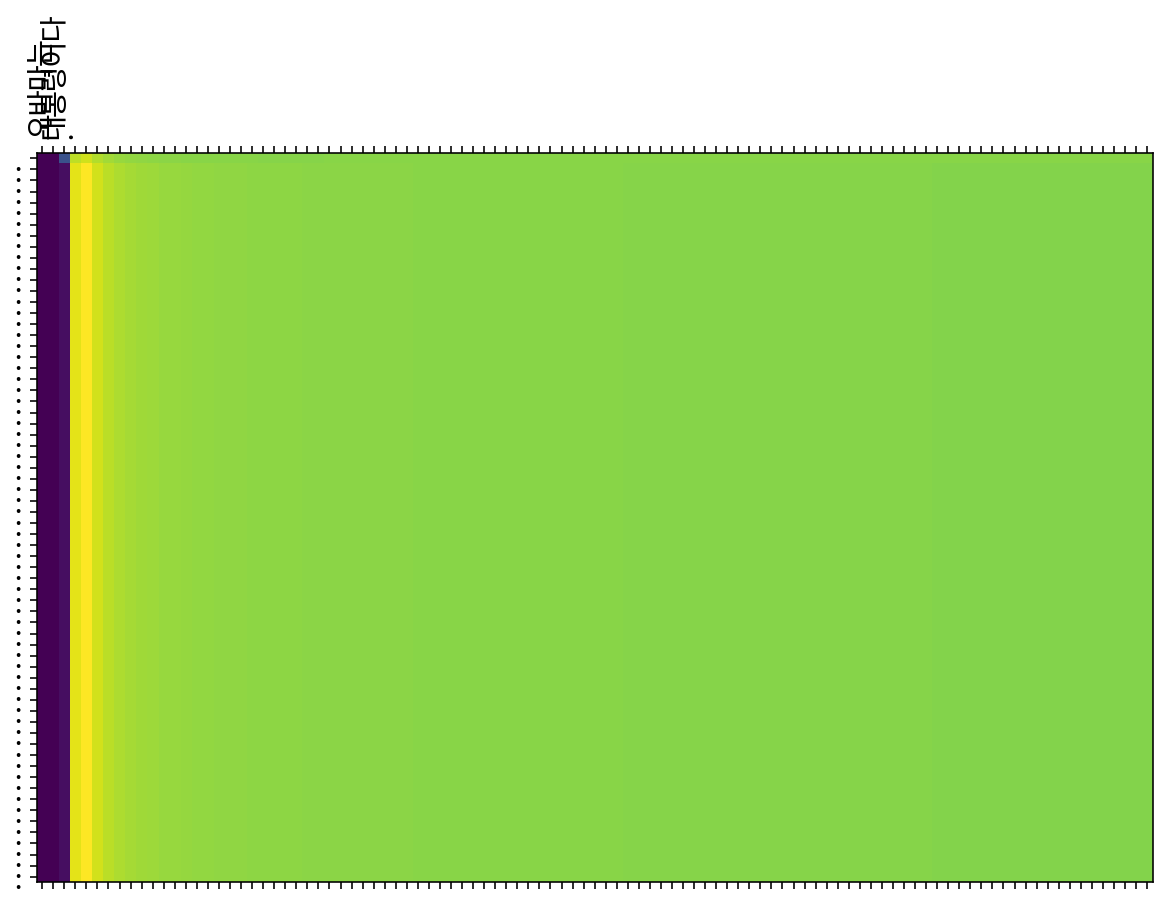

input: 시민들은 도시 속에 산다 .
output: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


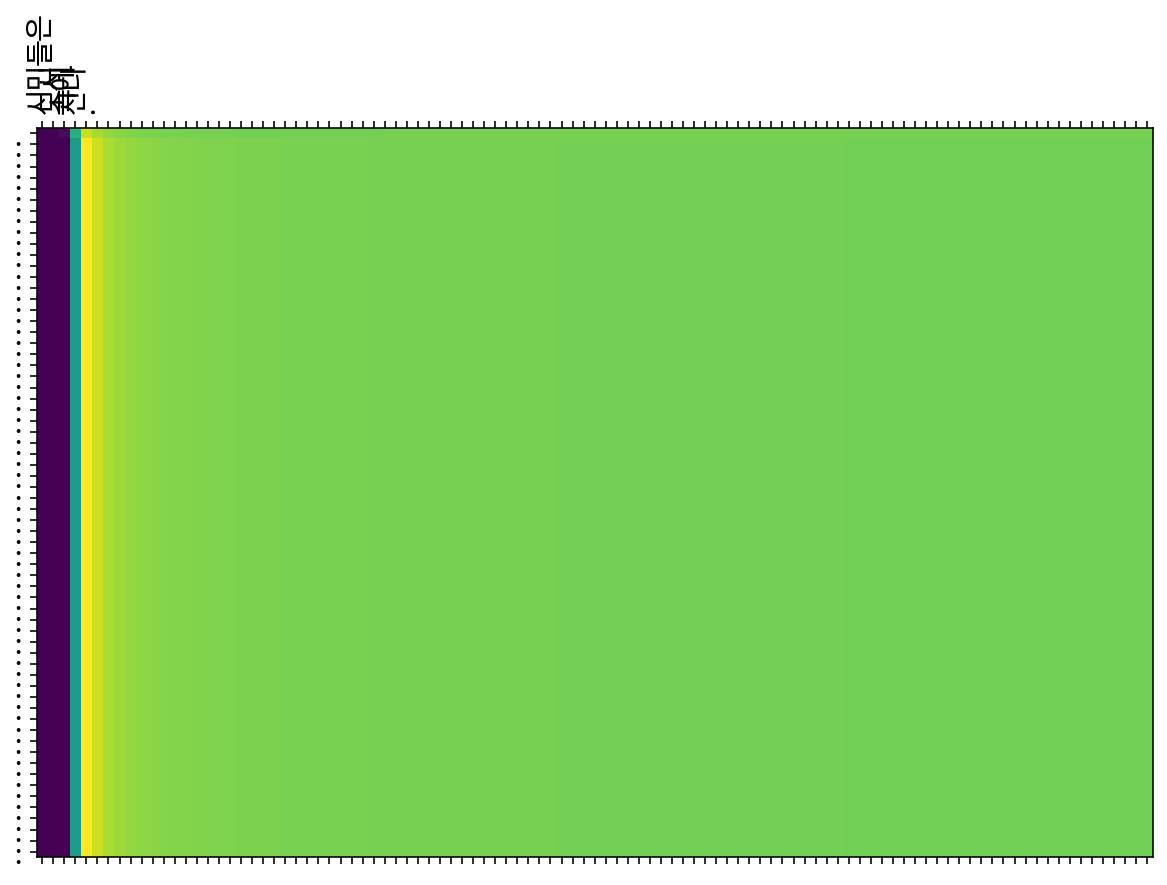

input: 커피는 필요 없다 .
output: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


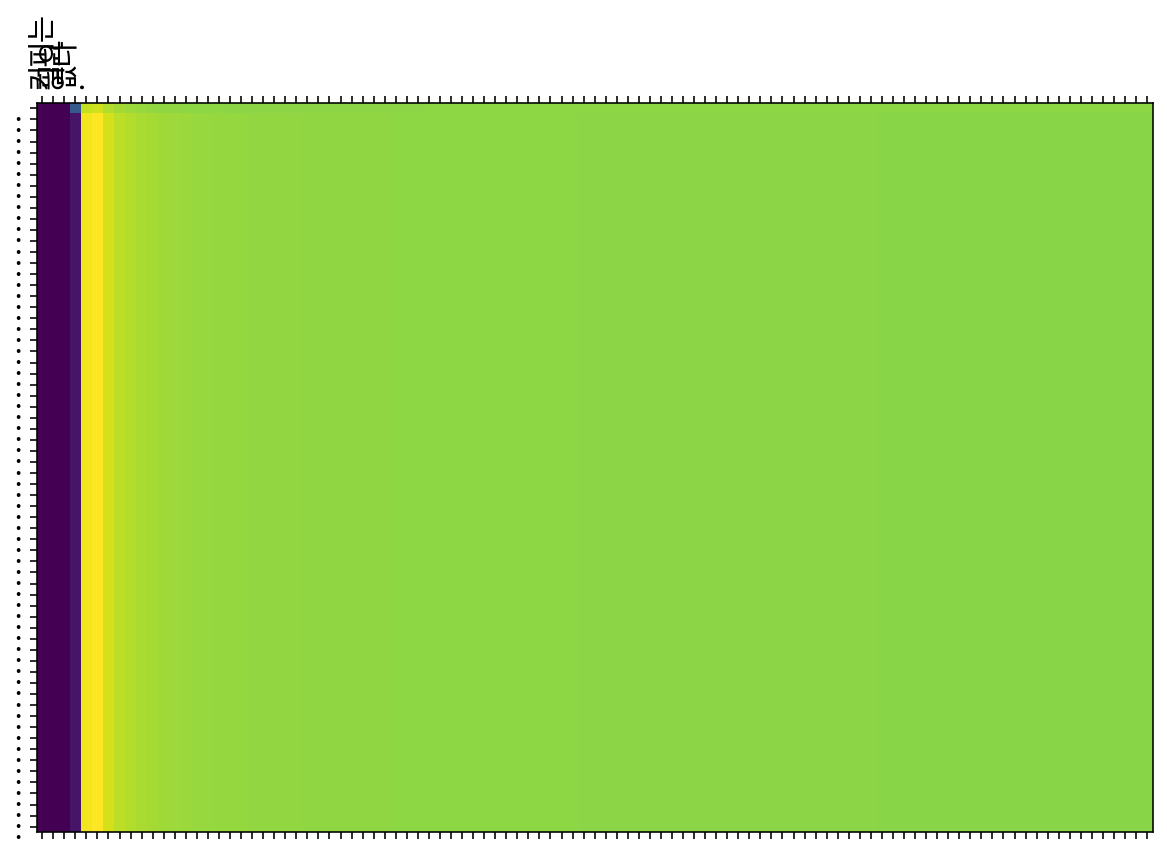

input: 일곱 명의 사망자가 발생했다 .
output: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


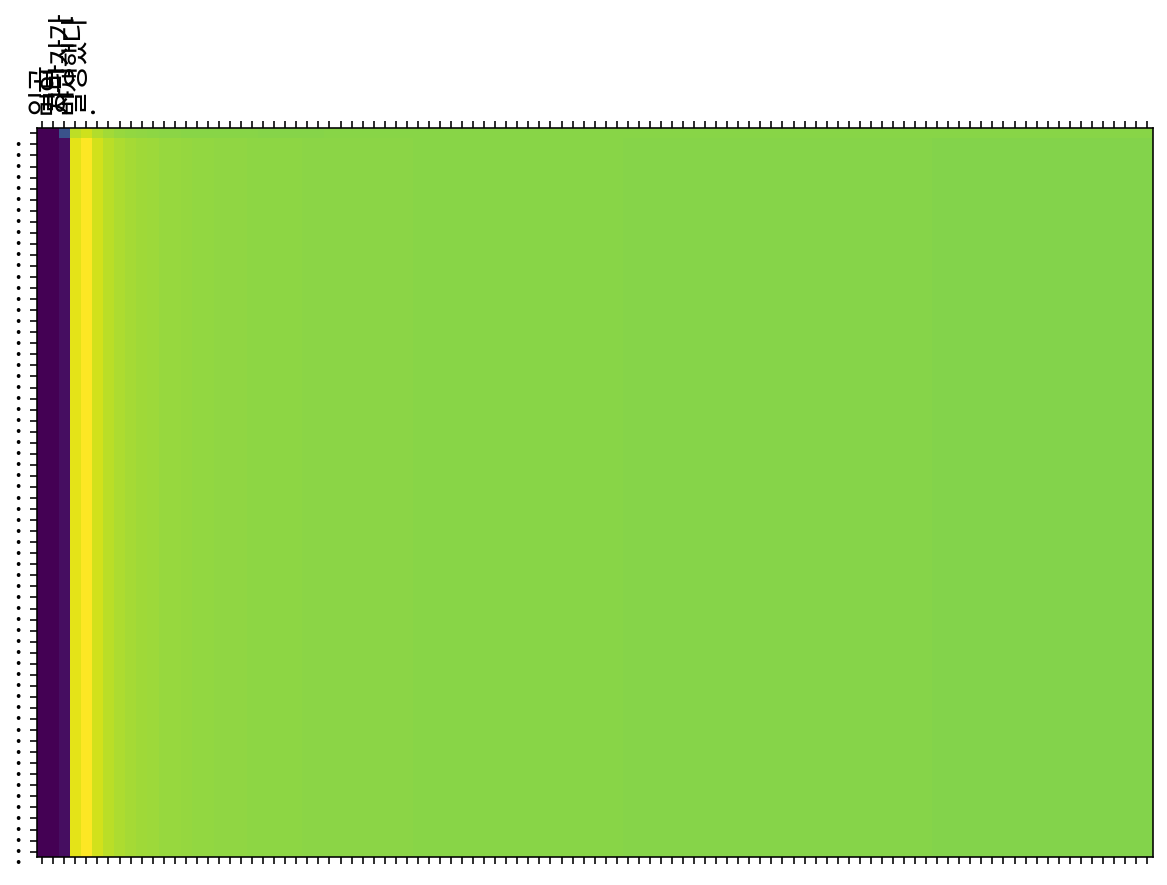

In [53]:
# 번역할 문장 리스트
input_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

# 각 문장에 대해 번역 실행
for sentence in input_sentences:
    translated_sentence, processed_input, attention = evaluate(sentence, encoder, decoder)

    # 번역 결과 출력
    print(f"input: {processed_input}")
    print(f"output: {translated_sentence}")

    # Attention Map 시각화
    plot_attention(attention, processed_input, translated_sentence)

### 두번째 시도
- num_examples : 30000
- BATCH_SIZE   : 16
- units        : 256
- embedding_dim: 128

input: 오바마는 대통령이다 .
output: . <end> 


/tmp/ipykernel_84/656357223.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence.split(), fontdict=fontdict, rotation=90)
/tmp/ipykernel_84/656357223.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence.split(), fontdict=fontdict)


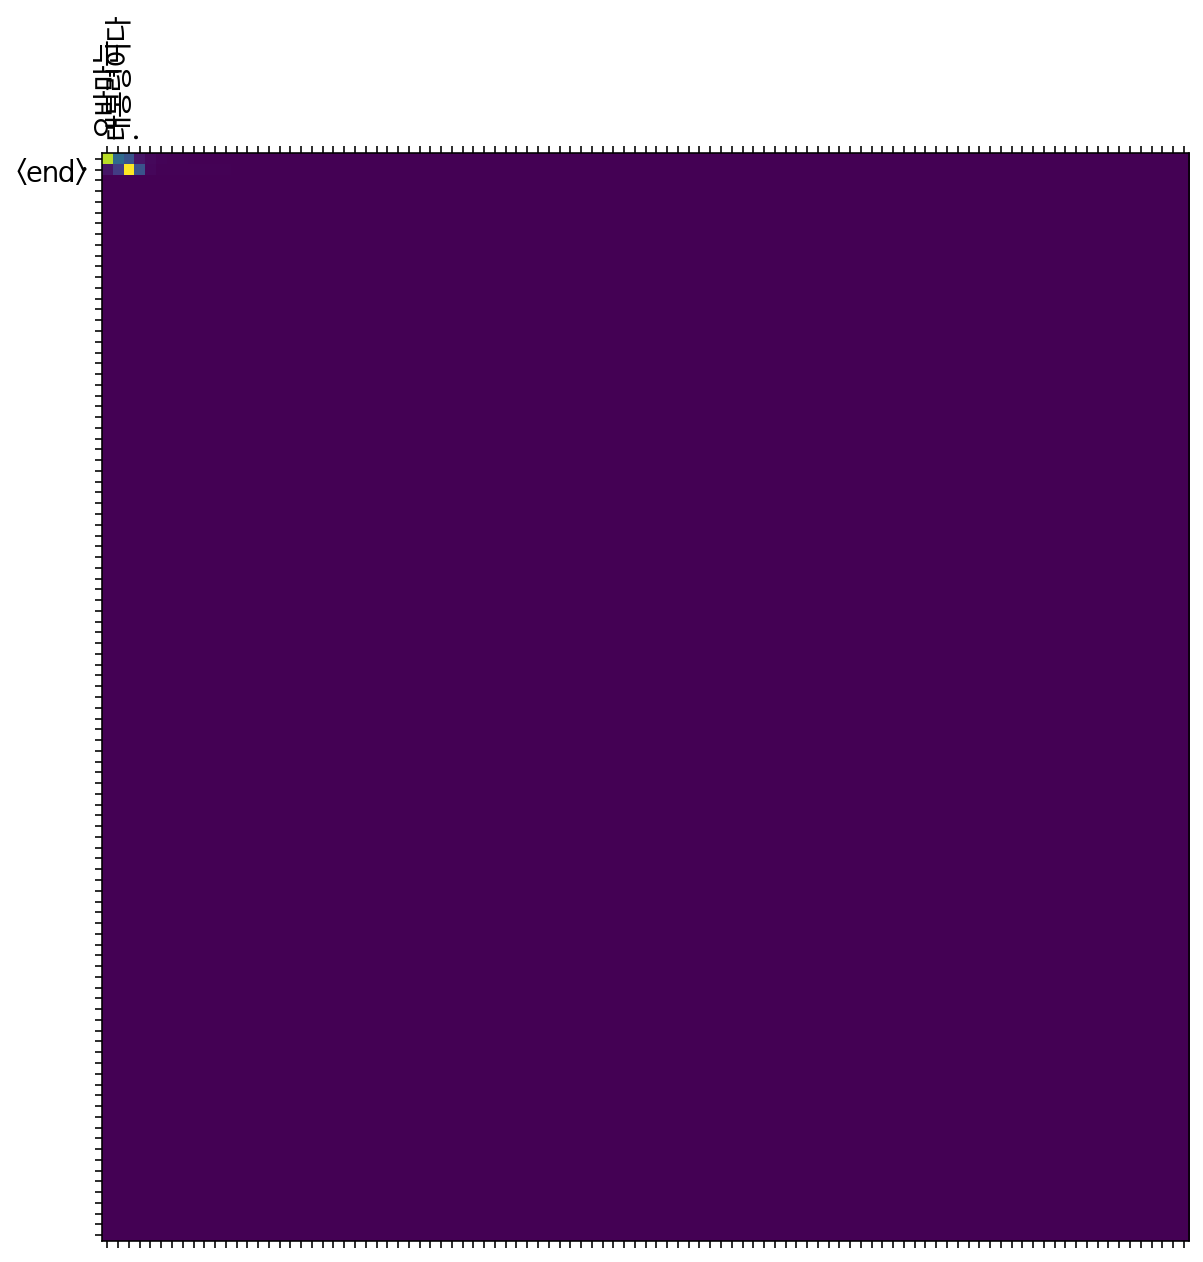

input: 시민들은 도시 속에 산다 .
output: . <end> 


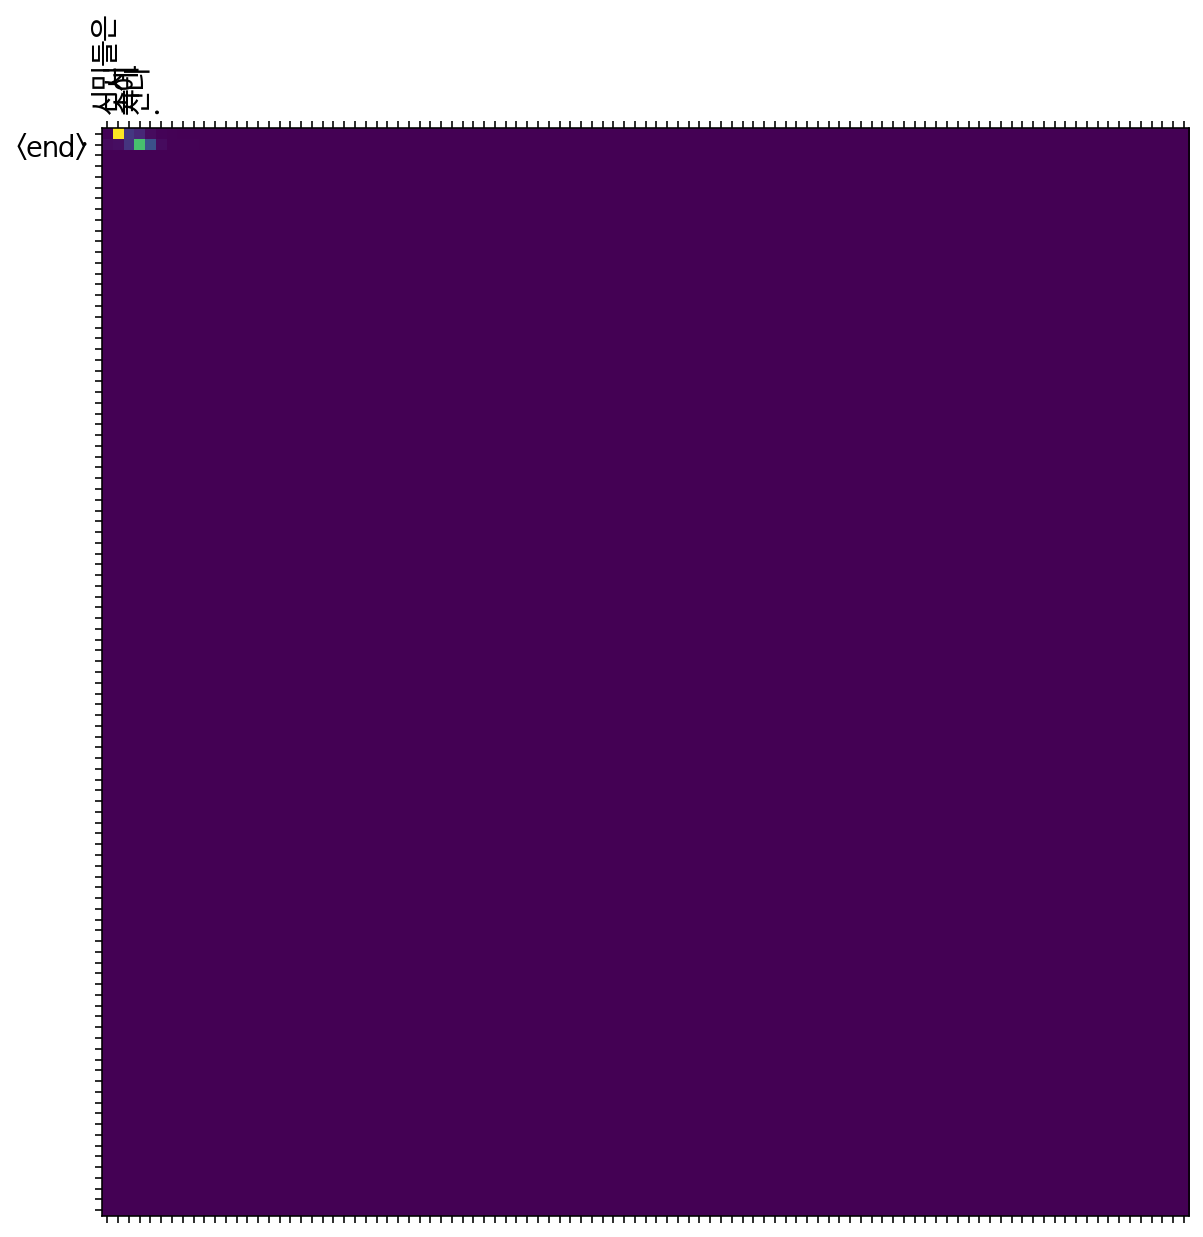

input: 커피는 필요 없다 .
output: it s not to the first time . <end> 


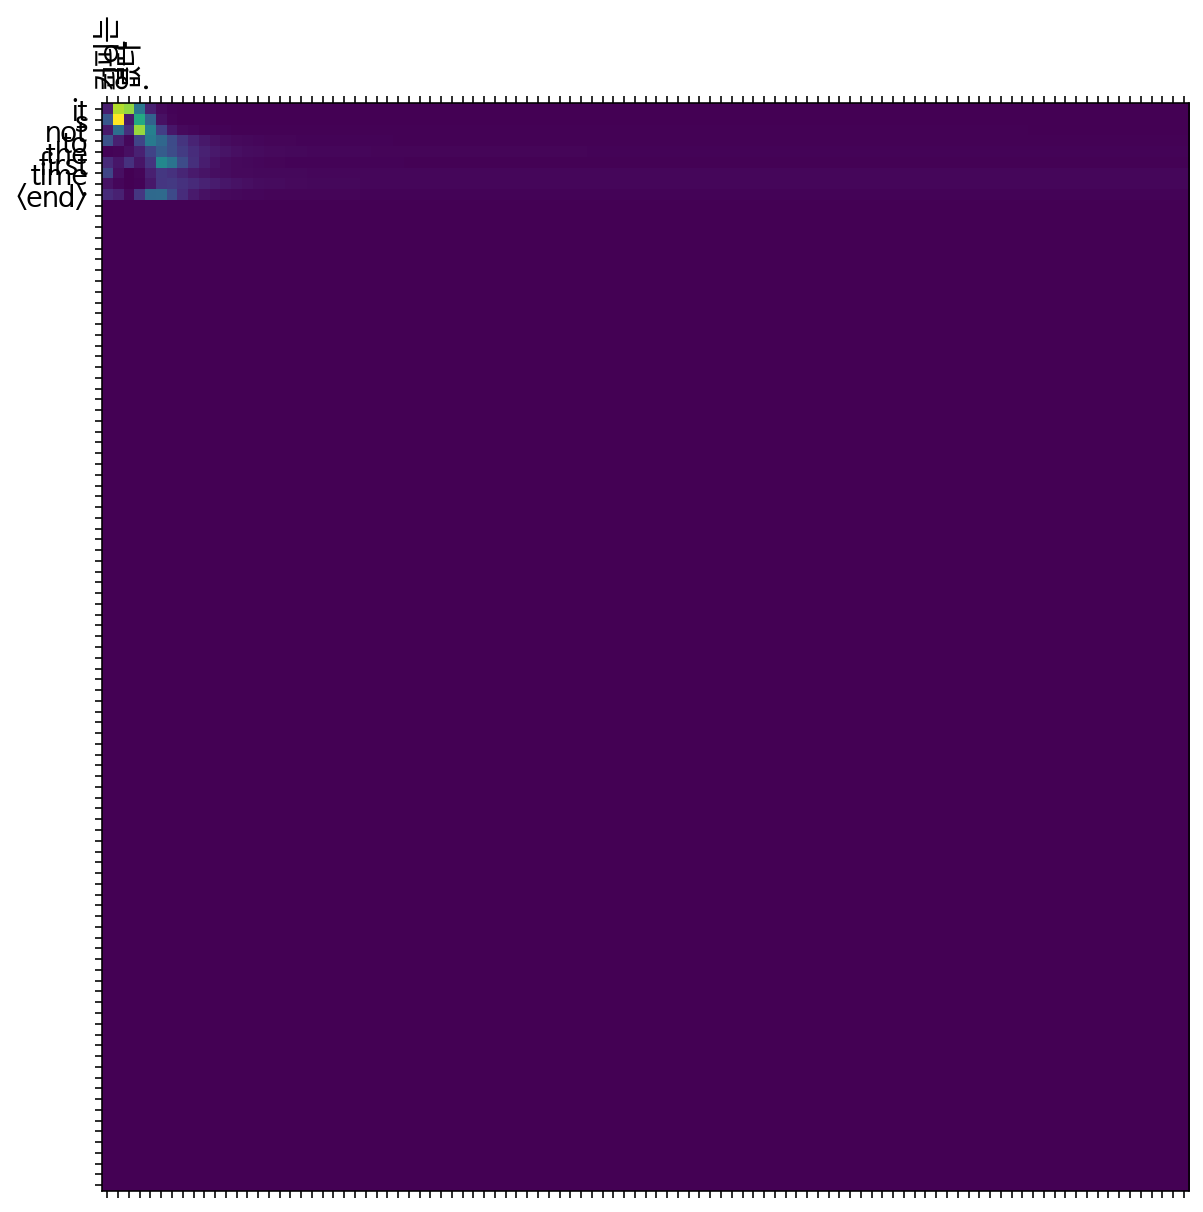

input: 일곱 명의 사망자가 발생했다 .
output: the government , the government . <end> 


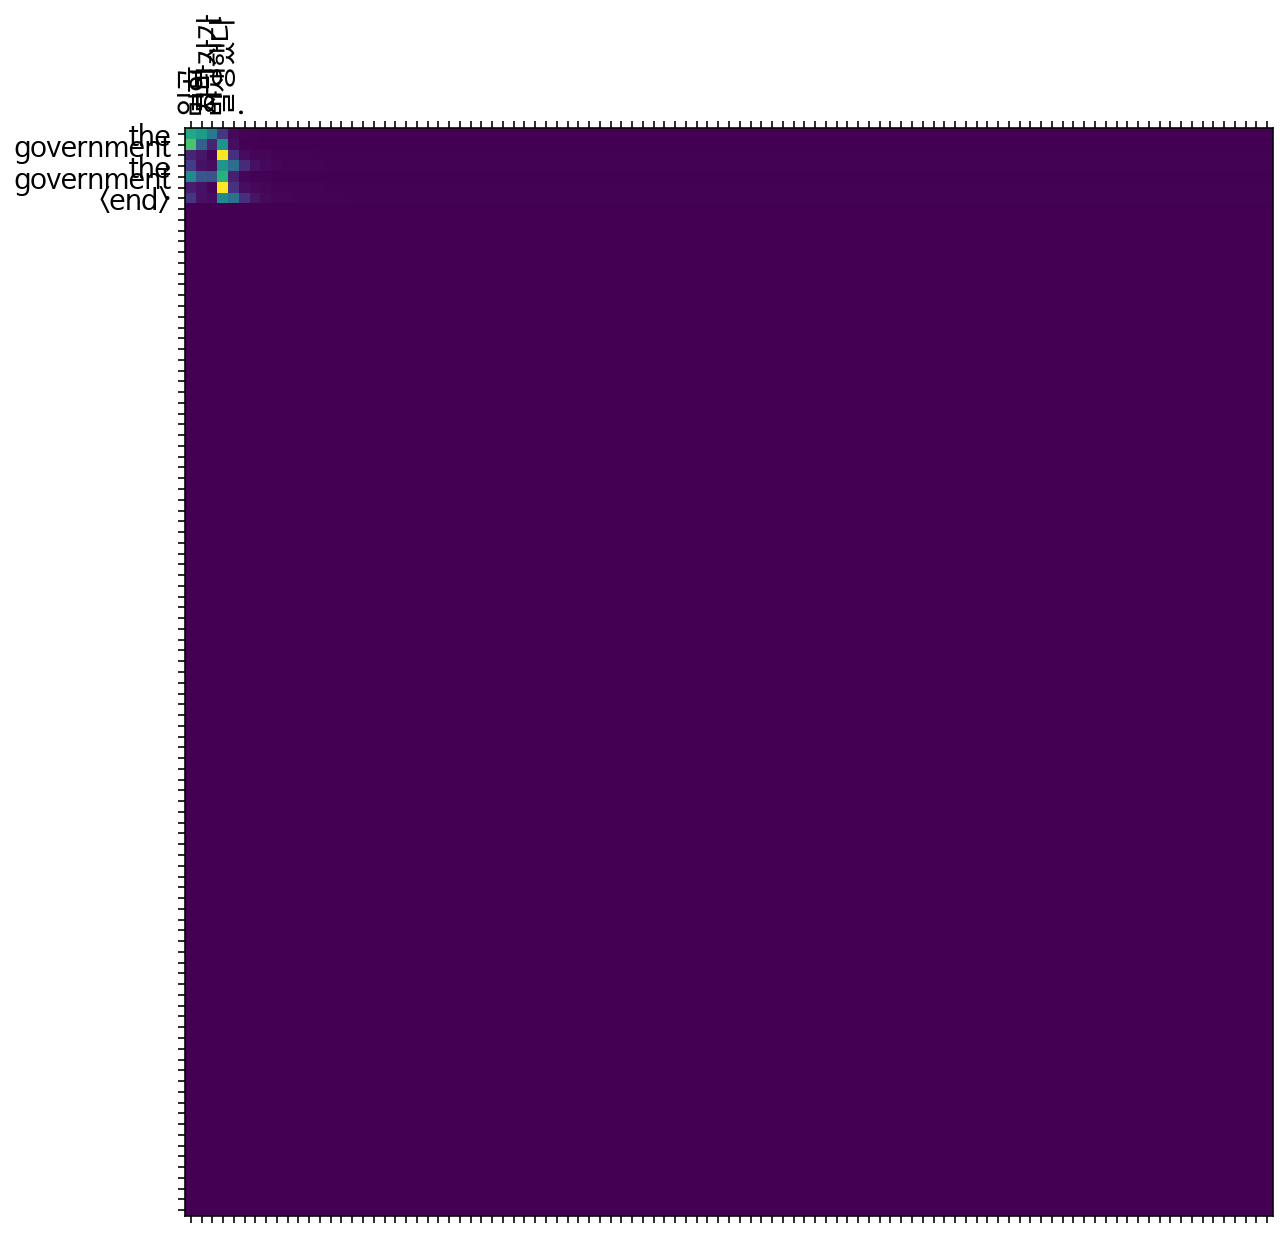

In [80]:
# 번역할 문장 리스트
input_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

# 각 문장에 대해 번역 실행
for sentence in input_sentences:
    translated_sentence, processed_input, attention = evaluate(sentence, encoder, decoder)

    # 번역 결과 출력
    print(f"input: {processed_input}")
    print(f"output: {translated_sentence}")

    # Attention Map 시각화
    plot_attention(attention, processed_input, translated_sentence)

### 세번째 시도
- num_examples : 10000
- BATCH_SIZE   : 32
- units        : 256
- embedding_dim: 128
- padding maxlen : 한글 30, 영어 40

input: 오바마는 대통령이다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_84/656357223.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence.split(), fontdict=fontdict, rotation=90)
/tmp/ipykernel_84/656357223.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence.split(), fontdict=fontdict)


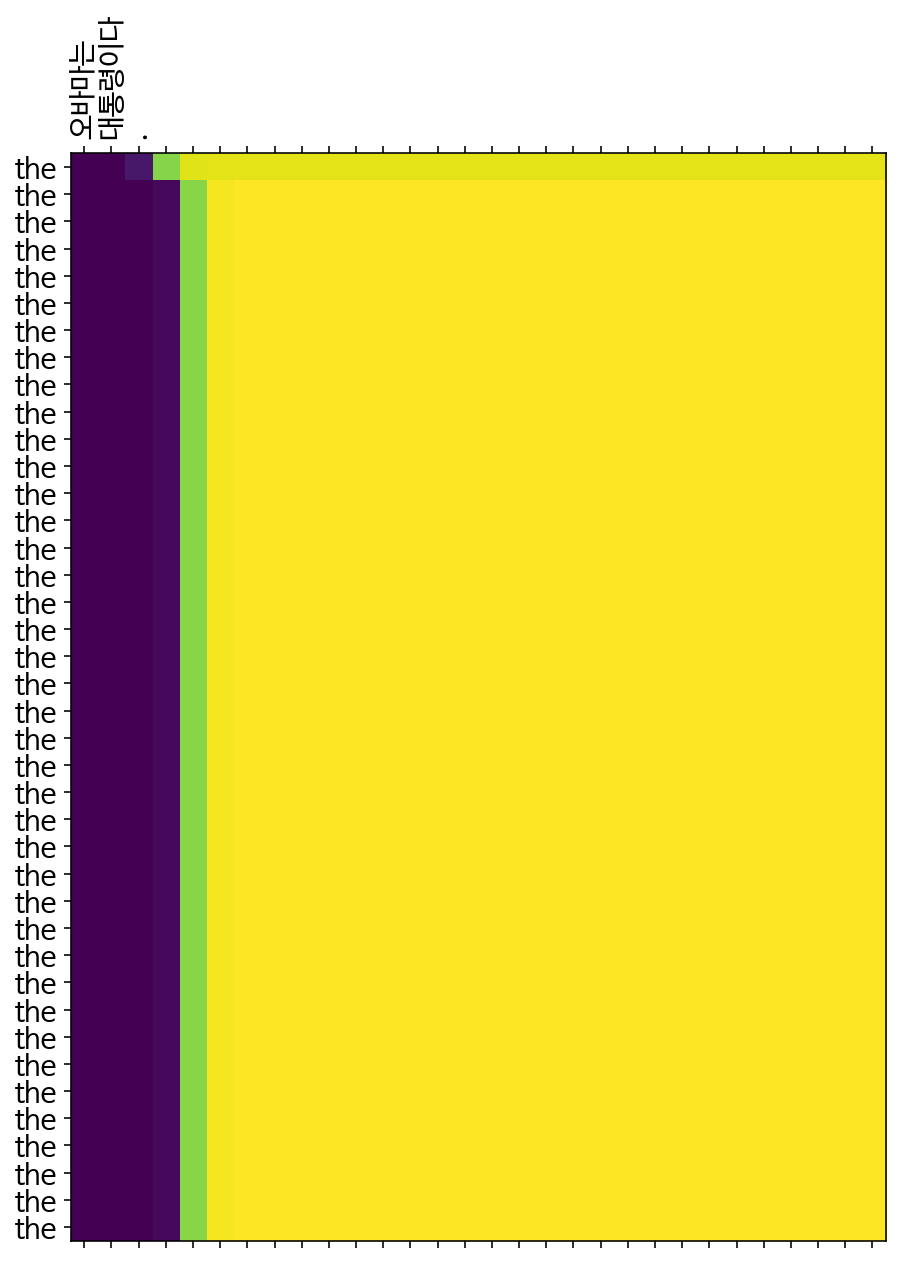

input: 시민들은 도시 속에 산다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


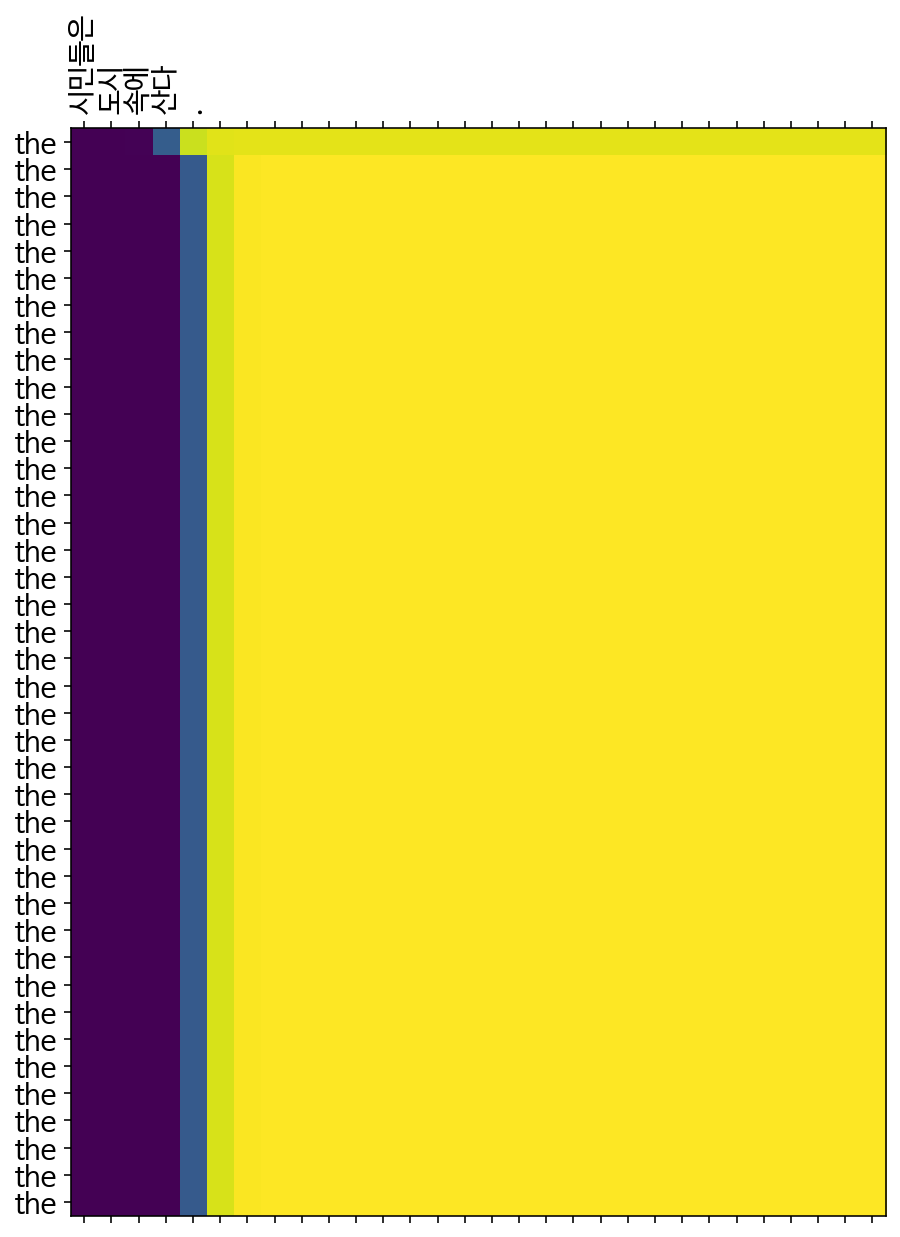

input: 커피는 필요 없다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


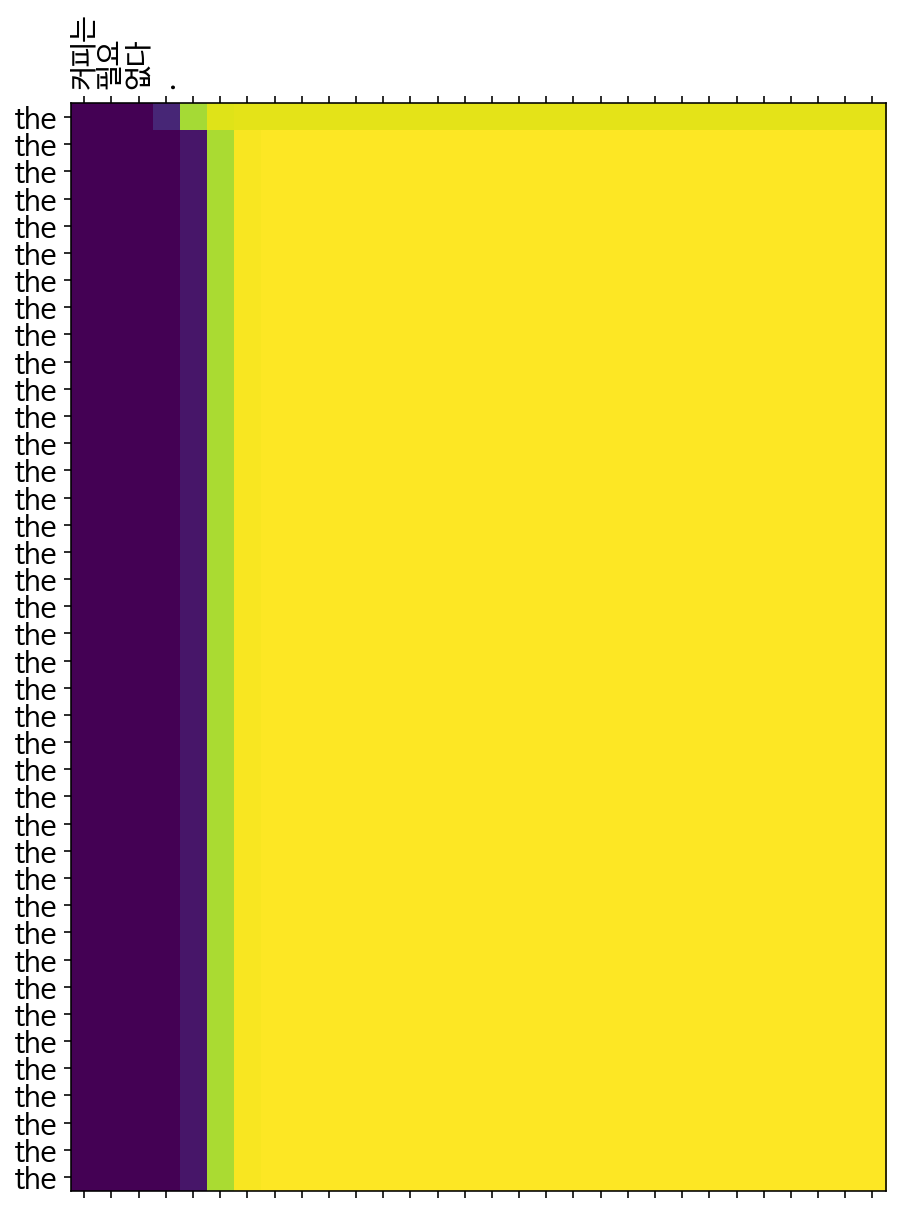

input: 일곱 명의 사망자가 발생했다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


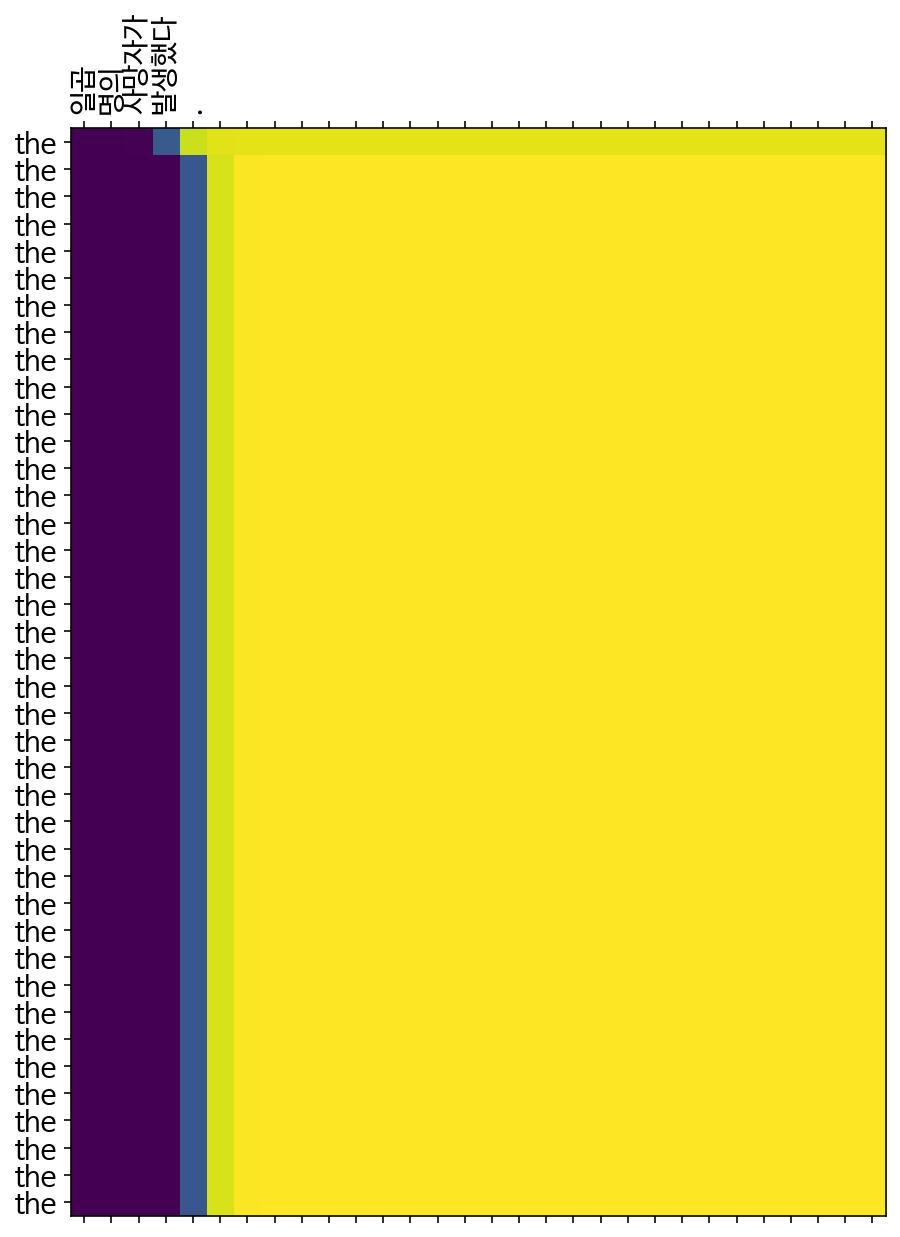

In [99]:
# 번역할 문장 리스트
input_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

# 각 문장에 대해 번역 실행
for sentence in input_sentences:
    translated_sentence, processed_input, attention = evaluate(sentence, encoder, decoder)

    # 번역 결과 출력
    print(f"input: {processed_input}")
    print(f"output: {translated_sentence}")

    # Attention Map 시각화
    plot_attention(attention, processed_input, translated_sentence)

### 네번째 시도
- num_examples : 50000
- BATCH_SIZE   : 32
- units        : 256
- embedding_dim: 128
- padding maxlen : 한글 30, 영어 40

input: 오바마는 대통령이다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_84/656357223.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence.split(), fontdict=fontdict, rotation=90)
/tmp/ipykernel_84/656357223.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence.split(), fontdict=fontdict)


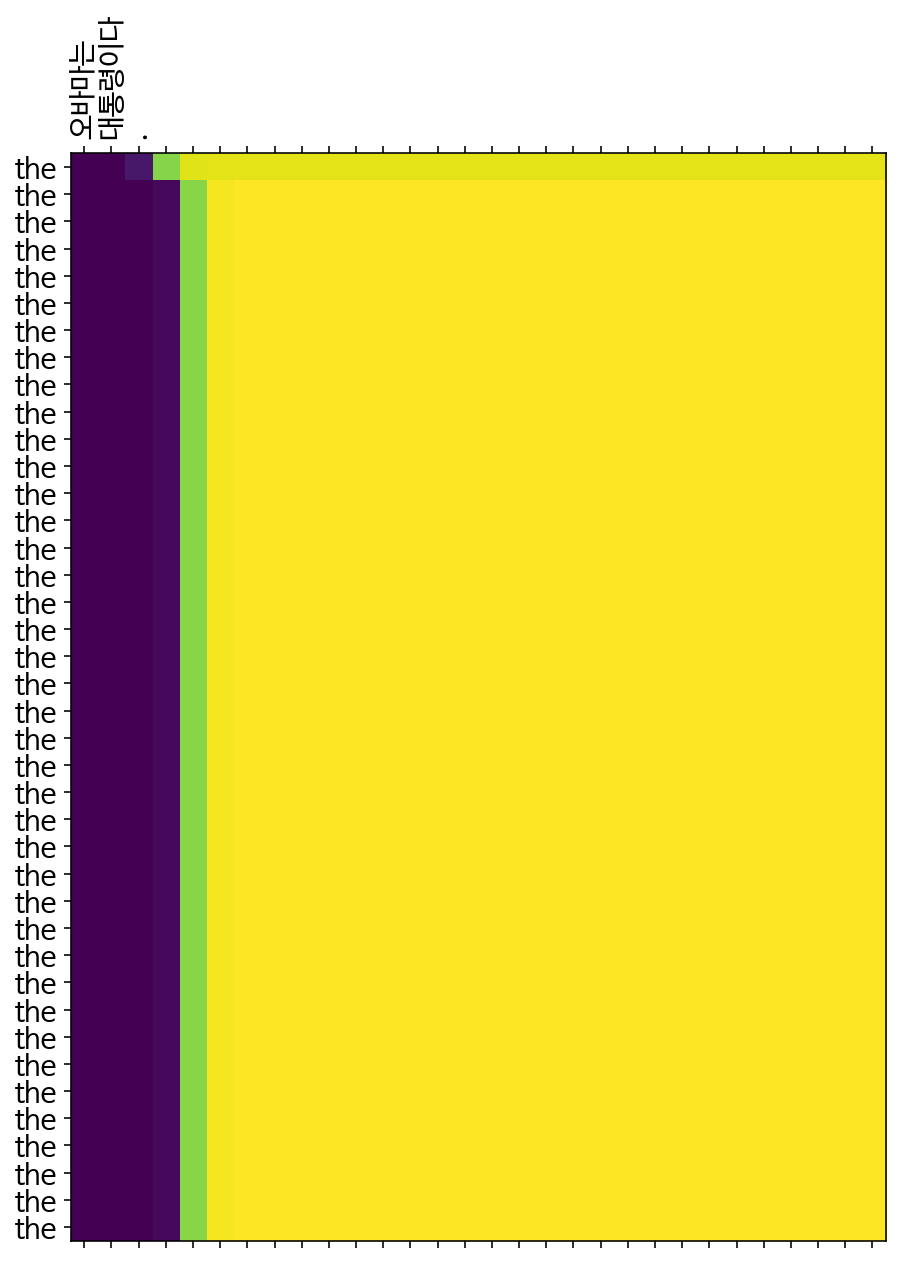

input: 시민들은 도시 속에 산다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


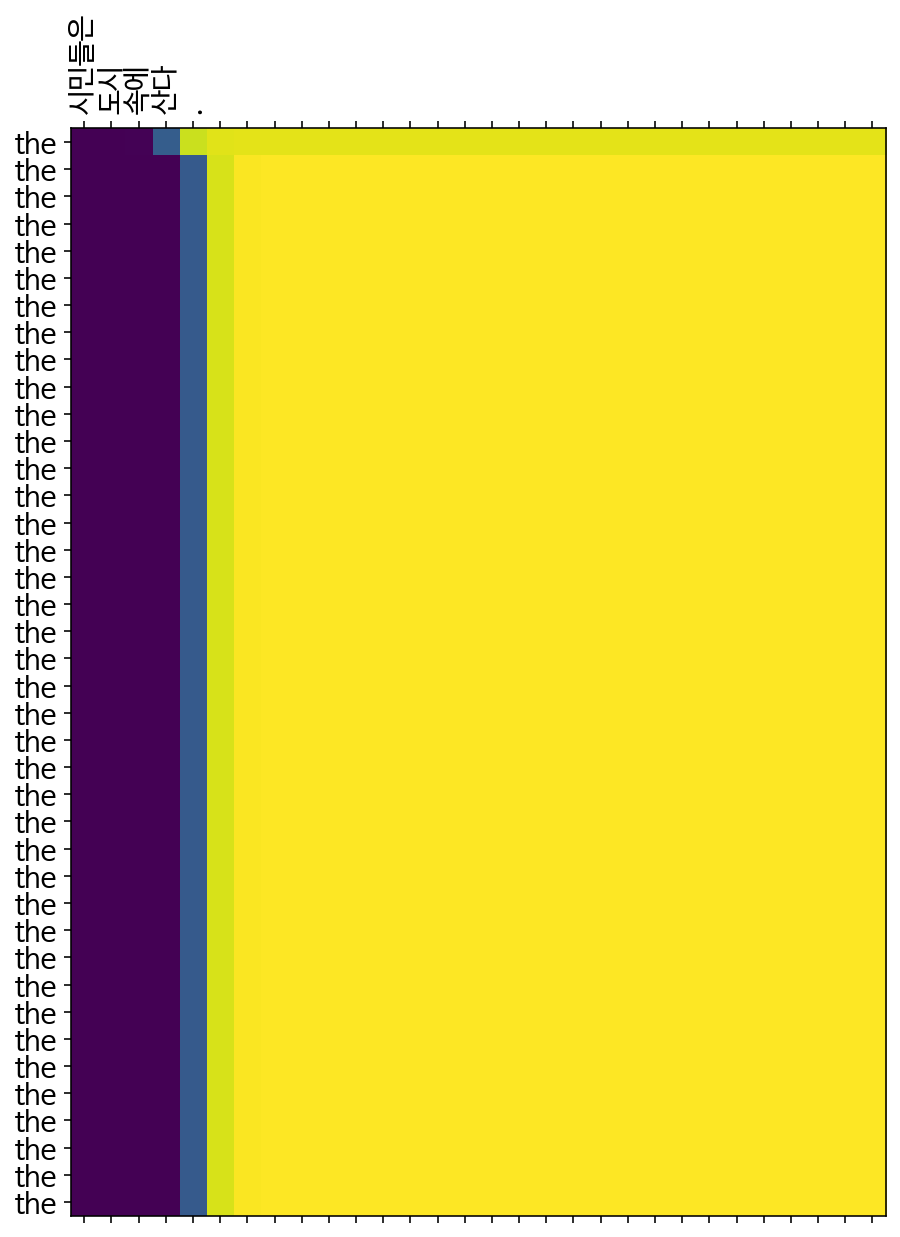

input: 커피는 필요 없다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


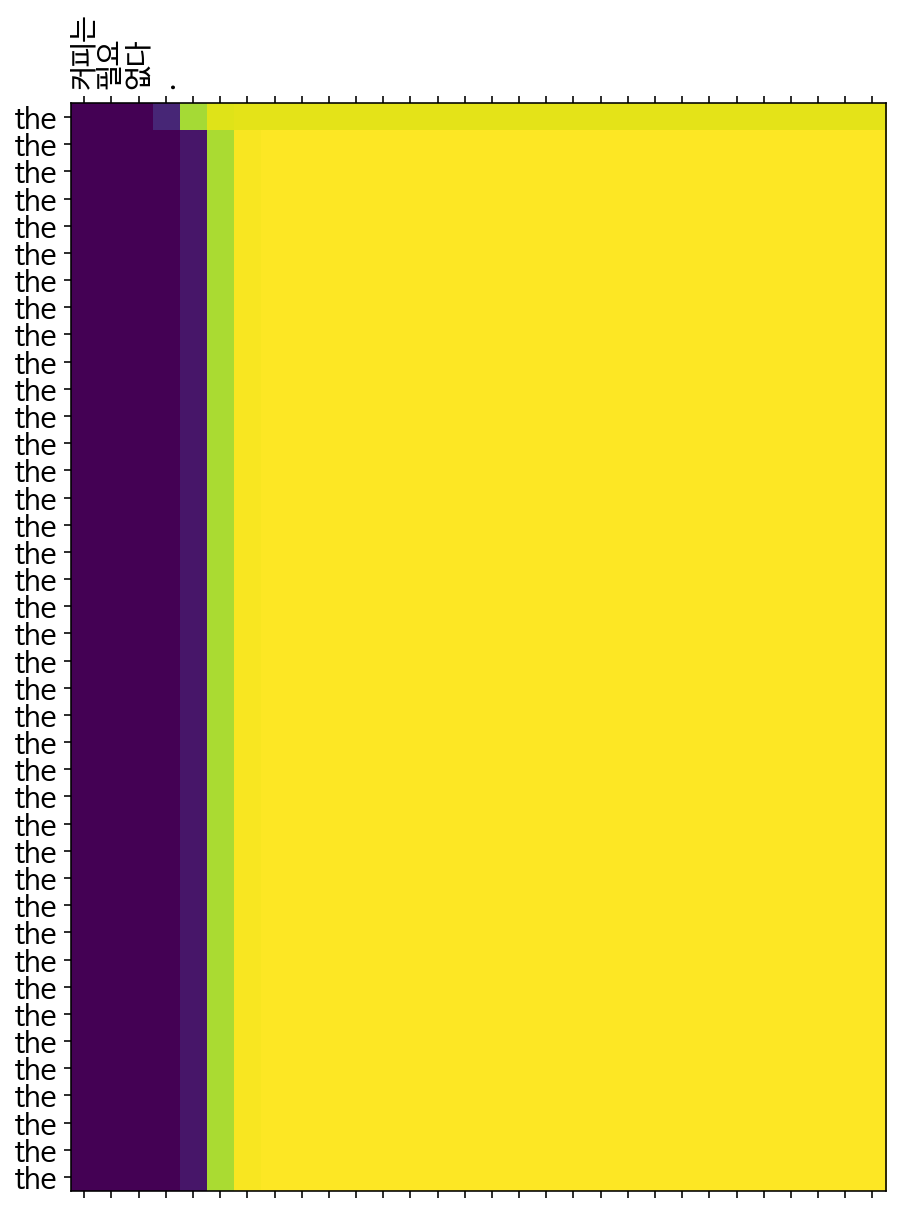

input: 일곱 명의 사망자가 발생했다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


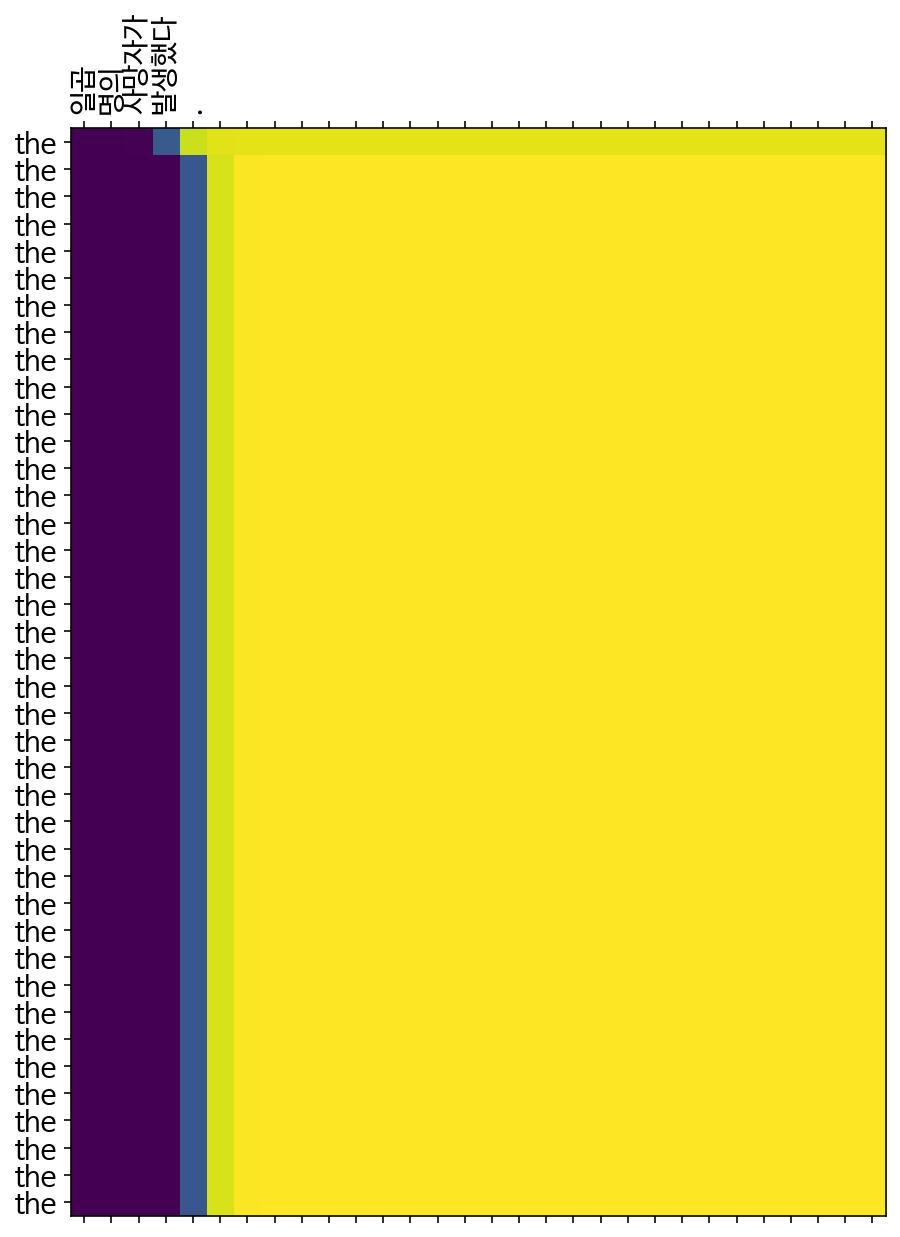

In [101]:
# 번역할 문장 리스트
input_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

# 각 문장에 대해 번역 실행
for sentence in input_sentences:
    translated_sentence, processed_input, attention = evaluate(sentence, encoder, decoder)

    # 번역 결과 출력
    print(f"input: {processed_input}")
    print(f"output: {translated_sentence}")

    # Attention Map 시각화
    plot_attention(attention, processed_input, translated_sentence)

### 다섯번째 시도
- num_examples : 50000
- BATCH_SIZE   : 32
- units        : 256
- embedding_dim: 128
- padding maxlen : 한글 60, 영어 60

In [123]:
# 번역할 문장 리스트
input_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

# 각 문장에 대해 번역 실행
for sentence in input_sentences:
    translated_sentence, processed_input, attention = evaluate(sentence, encoder, decoder)

    # 번역 결과 출력
    print(f"input: {processed_input}")
    print(f"output: {translated_sentence}")

input: 오바마는 대통령이다 .
output: the new york is a new york . <end> 
input: 시민들은 도시 속에 산다 .
output: the city is a new york . <end> 
input: 커피는 필요 없다 .
output: the dow is not be able to be a lot of the first time . <end> 
input: 일곱 명의 사망자가 발생했다 .
output: the city is a new york . <end> 


### 여섯번째 시도
- num_examples : 50000
- BATCH_SIZE   : 32
- units        : 512
- embedding_dim: 256
- padding maxlen : 한글 60, 영어 60

In [26]:
# 번역할 문장 리스트
input_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

# 각 문장에 대해 번역 실행
for sentence in input_sentences:
    translated_sentence, processed_input, attention = evaluate(sentence, encoder, decoder)

    # 번역 결과 출력
    print(f"input: {processed_input}")
    print(f"output: {translated_sentence}")

input: 오바마는 대통령이다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
input: 시민들은 도시 속에 산다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
input: 커피는 필요 없다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
input: 일곱 명의 사망자가 발생했다 .
output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

- num_examples : 50000
- BATCH_SIZE   : 32
- units        : 256
- embedding_dim: 128
- padding maxlen : 한글 60, 영어 60

- 학습이 정상적으로 진행되지않았다.
- 패딩 관련 전처리 진행했을 때 비교적 상황이 번역기스럽게 답함.
- but, 그러나 정상적인 답변은 아님
- 